## Using a non-linear model to fit to predictors and predict a target

#### This is an example of a single input single output system (SISO)

In [19]:
import pandas as pd
import numpy as np

import os
current_wd = os.getcwd()
os.chdir(current_wd.split("scikit-identification")[0] + "scikit-identification")
from skmid.integrator import RungeKutta4
from skmid.model_training import DynamicModel, LeastSquaresRegression
from skmid.models import generate_model_attributes
os.chdir(current_wd)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

In [12]:
if "skmid" in plt.style.available:
    plt.style.use("skmid")

#### Read in the data

In [2]:
df = pd.concat([pd.read_csv("../data/non_linear_model/u_data.csv", index_col=0),
pd.read_csv("../data/non_linear_model/y_data.csv", index_col=0)], axis=1)

Y = df[["y"]]
U = df[["u"]].dropna()

#### Define the model (generate the attributes, and set the model with the defined attributes)

In [3]:
(state, input, param) = generate_model_attributes(
    state_size=2, input_size=1, parameter_size=4
)
y, dy = state[0], state[1]
u = input[0]
M, c, k, k_NL = param[0], param[1], param[2], param[3]
rhs = [dy, (u - k_NL * y**3 - k * y - c * dy) / M] # this is where the main equation is defined

model = DynamicModel(
    state=state,
    input=input,
    parameter=param,
    input_name=["u"],
    parameter_name=["M", "c", "k", "k_NL"],
    state_name=["y", "dy"],
    output=["y"],
    model_dynamics=rhs,
)

#### Define the input settings

In [4]:
settings = {
    "N": 10000,
    "fs": 610.1,
    "param_truth": [5.625e-6, 2.3e-4, 1, 4.69],
    "param_guess": [5, 2, 1, 5],
    "scale": [1e-6, 1e-4, 1, 1],
    "n_steps_per_sample": 10,
    "initial_condition": [0, 0]
}

#### Call the estimator (here Least Squares Regression is used)

In [5]:
fs = settings["fs"]
n_steps_per_sample = settings["n_steps_per_sample"]
estimator = LeastSquaresRegression(
    model=model, fs=fs, n_steps_per_sample=n_steps_per_sample
)

#### Create initial condition

In [6]:
Yg = Y.values[1:]
yd = np.diff(Yg, axis=0) * fs
yd = np.concatenate([yd, yd[-1].reshape(1, -1)], axis=0)
state_guess = np.concatenate([Yg, yd], axis=1)

#### Estimate parameters

In [7]:
param_guess = settings["param_guess"]
scale = settings["scale"]

#### Fit the model

In [8]:
estimator.fit(
    U=U, Y=Y, param_guess=param_guess, param_scale=scale, 
    state_guess=state_guess
)

just-in-time compilation with compiler= "shell" 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:   139986
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   110010

Total number of variables............................:    20004
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with

#### Save the output (parameter estimates, predictions and model fit)

In [9]:
param_est = estimator.coef_

y_fit = estimator.predict(U=U, initial_condition=list(state_guess[0, :]))

x_fit = estimator.model_fit_

INFO:The input index has a different fs than specified in the object.
                                  The input index has been modified by using fs=610.1 Hz.
                                


#### Compare the estimated parameters vs the initial guessed parameters

In [16]:
param_est, param_guess

(array([5.625e-06, 2.300e-04, 1.000e+00, 4.690e+00]), [5, 2, 1, 5])

#### Save the input, actual target and prediction in a data frame

In [17]:
pred_df = pd.DataFrame({"u": U["u"].values,
              "y": Y["y"].values[1:],
              "y_predict": y_fit["y"].values[1:]})

#### Plot the first 500 data points to get an idea of how close the real target and the prediction are

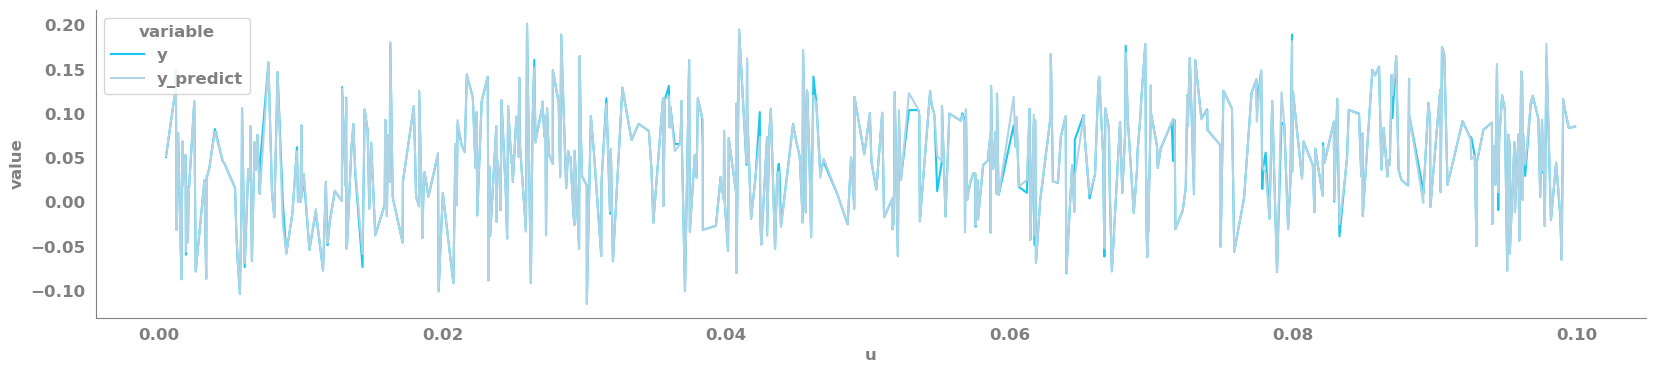

In [18]:
_ = plt.figure(figsize=(20, 4))
_ = sns.lineplot(data=pred_df.iloc[0:500, :].melt(id_vars="u"),
                 x="u",
                 y="value",
                 hue="variable")
_ = sns.despine()

#### Use the RMSE to quantify the difference between the real and predicted target

In [21]:
round(np.sqrt(mean_squared_error(y_true=pred_df["y"], y_pred=pred_df["y_predict"])), 5)

0.00142